# Using pre-trained convnet

![title](./pics/conv_pre_training.png)

In [1]:
# imports
import sys
import os, shutil
import numpy as np

# keras imports 
from keras import layers
from keras import models
from keras import optimizers
from keras.datasets import mnist
from keras.applications import VGG16
from keras.utils import to_categorical
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

# visualization imports
import matplotlib.pyplot as plt

%matplotlib inline

Using TensorFlow backend.


## Instantiating the VGG16 convolutional base

In [2]:
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

## Extracting features using the pre-trained convolutional base

In [3]:
# The path to the directory where the original
# dataset was uncompressed
dir_path =  os.getcwd()
base_dir = dir_path + '/cats_and_dogs_small'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20
def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i =0
    for inputs_batch, labels_batch in generator:
            features_batch = conv_base.predict(inputs_batch)
            features[i * batch_size : (i + 1) * batch_size] = features_batch
            labels[i * batch_size : (i + 1) * batch_size] = labels_batch
            i += 1
            if i * batch_size >= sample_count:
                # Note that since generators yield data indefinitely in a loop,
                # we must `break` after every image has been seen once.
                break
    return features, labels
train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


## Using the feature vectors to train dense model

In [4]:
# model architecture and training
model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',metrics=['acc'])
history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 1s 436us/step - loss: 0.6084 - acc: 0.6555 - val_loss: 0.4373 - val_acc: 0.8420
Epoch 2/30
2000/2000 [==============================] - 1s 271us/step - loss: 0.4333 - acc: 0.8090 - val_loss: 0.3580 - val_acc: 0.8600
Epoch 3/30
2000/2000 [==============================] - 1s 276us/step - loss: 0.3475 - acc: 0.8580 - val_loss: 0.3163 - val_acc: 0.8790
Epoch 4/30
2000/2000 [==============================] - 1s 272us/step - loss: 0.3141 - acc: 0.8685 - val_loss: 0.3072 - val_acc: 0.8870
Epoch 5/30
2000/2000 [==============================] - 1s 277us/step - loss: 0.2842 - acc: 0.8815 - val_loss: 0.2782 - val_acc: 0.8870
Epoch 6/30
2000/2000 [==============================] - 1s 276us/step - loss: 0.2615 - acc: 0.8955 - val_loss: 0.2710 - val_acc: 0.8900
Epoch 7/30
2000/2000 [==============================] - 1s 274us/step - loss: 0.2401 - acc: 0.9100 - val_loss: 0.2614 - val_acc: 0.8990


In [6]:
# function to plot model training logs
def plot_model_training_history(history_dict, plot_val=True,chart_type="--o"):
    acc = history_dict['acc']
    loss = history_dict['loss']
    
    if plot_val:
        val_acc = history_dict['val_acc']
        val_loss = history_dict['val_loss']
    epochs = range(1, len(acc) + 1)

    # visualize model training
    epochs = range(1, len(acc) + 1)
    fig, axs = plt.subplots(1, 2,figsize=(15,5))
    axs[0].plot(epochs, loss, chart_type, label='Training loss')
    if plot_val:
        axs[0].plot(epochs, val_loss, chart_type, label='Validation loss')
        axs[0].set_title('training & validation loss')
    else:
        axs[0].set_title('training loss')
                               
    axs[1].plot(epochs, acc, chart_type, label='Training acc')
    if plot_val:
        axs[1].plot(epochs, val_acc, chart_type, label='Validation acc')
        axs[1].set_title('training & validation accuracy')                      
    else:
        axs[1].set_title('training accuracy')                      

    plt.show()
    plt.close()

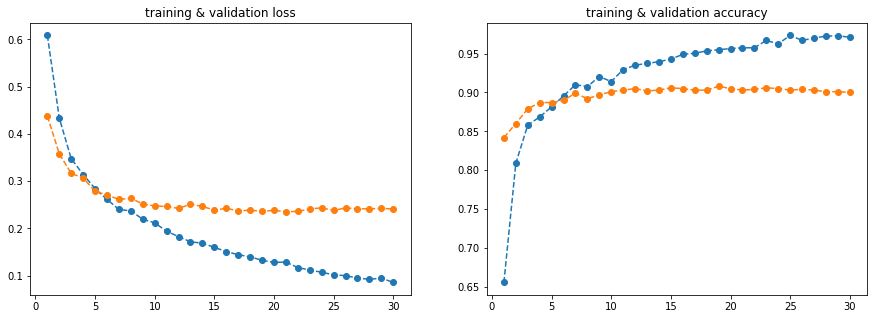

In [7]:
# plot model history
plot_model_training_history(history.history,chart_type="--o")

## Adding a densely-connected classifier on top of the convolutional base

In [8]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


## Freezing the convolutional base

In [9]:
print('This is the number of trainable weights before freezing the conv base:', len(model.trainable_weights))
conv_base.trainable = False
print('This is the number of trainable weights after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 30
This is the number of trainable weights after freezing the conv base: 4


## Training the model end-to-end with a frozen convolutional base

In [10]:
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')
validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
100/100 [==============================] - 13s 125ms/step - loss: 0.5752 - acc: 0.7105 - val_loss: 0.4396 - val_acc: 0.8230
Epoch 2/30
100/100 [==============================] - 11s 113ms/step - loss: 0.4762 - acc: 0.7900 - val_loss: 0.3637 - val_acc: 0.8580
Epoch 3/30
100/100 [==============================] - 11s 113ms/step - loss: 0.4128 - acc: 0.8215 - val_loss: 0.3541 - val_acc: 0.8490
Epoch 4/30
100/100 [==============================] - 11s 113ms/step - loss: 0.4150 - acc: 0.8135 - val_loss: 0.3109 - val_acc: 0.8760
Epoch 5/30
100/100 [==============================] - 11s 114ms/step - loss: 0.3825 - acc: 0.8300 - val_loss: 0.3044 - val_acc: 0.8770
Epoch 6/30
100/100 [==============================] - 11s 113ms/step - loss: 0.3664 - acc: 0.8450 - val_loss: 0.2844 - val_acc: 0.8780
Epoch 7/30
100/100 [==============================] - 11s 114ms/step - loss: 0.3512 - acc: 0.8525 - val_lo

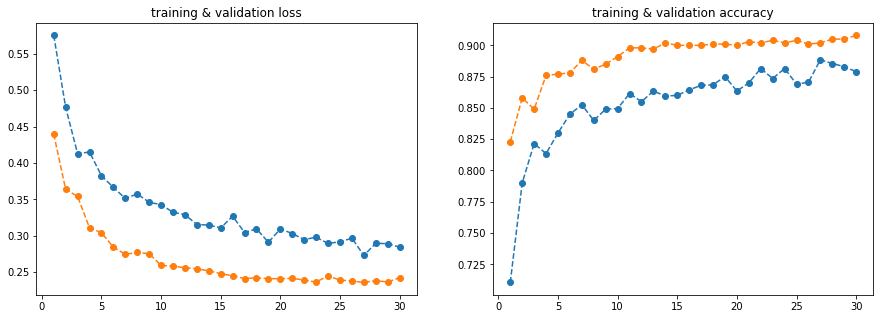

In [11]:
# plot model history
plot_model_training_history(history.history,chart_type="--o")

## Freezing all layers up to a specific one

In [12]:
conv_base.trainable = True
set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

## Fine-tuning our model

In [13]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50)

Epoch 1/100
100/100 [==============================] - 13s 128ms/step - loss: 0.2787 - acc: 0.8815 - val_loss: 0.2295 - val_acc: 0.9140
Epoch 2/100
100/100 [==============================] - 12s 116ms/step - loss: 0.2782 - acc: 0.8835 - val_loss: 0.2443 - val_acc: 0.9100
Epoch 3/100
100/100 [==============================] - 11s 115ms/step - loss: 0.2451 - acc: 0.8965 - val_loss: 0.2048 - val_acc: 0.9210
Epoch 4/100
100/100 [==============================] - 11s 114ms/step - loss: 0.2140 - acc: 0.9100 - val_loss: 0.1936 - val_acc: 0.9260
Epoch 5/100
100/100 [==============================] - 12s 117ms/step - loss: 0.2251 - acc: 0.9095 - val_loss: 0.2170 - val_acc: 0.9210
Epoch 6/100
100/100 [==============================] - 12s 119ms/step - loss: 0.2017 - acc: 0.9125 - val_loss: 0.2028 - val_acc: 0.9220
Epoch 7/100
100/100 [==============================] - 12s 116ms/step - loss: 0.1751 - acc: 0.9295 - val_loss: 0.2185 - val_acc: 0.9160
Epoch 8/100
100/100 [===========================

Epoch 61/100
100/100 [==============================] - 11s 114ms/step - loss: 0.0458 - acc: 0.9835 - val_loss: 0.3118 - val_acc: 0.9270
Epoch 62/100
100/100 [==============================] - 12s 115ms/step - loss: 0.0307 - acc: 0.9875 - val_loss: 0.3288 - val_acc: 0.9220
Epoch 63/100
100/100 [==============================] - 12s 116ms/step - loss: 0.0279 - acc: 0.9895 - val_loss: 0.2248 - val_acc: 0.9370
Epoch 64/100
100/100 [==============================] - 12s 115ms/step - loss: 0.0265 - acc: 0.9905 - val_loss: 0.2447 - val_acc: 0.9360
Epoch 65/100
100/100 [==============================] - 11s 114ms/step - loss: 0.0244 - acc: 0.9905 - val_loss: 0.2936 - val_acc: 0.9270
Epoch 66/100
100/100 [==============================] - 12s 117ms/step - loss: 0.0321 - acc: 0.9875 - val_loss: 0.2724 - val_acc: 0.9300
Epoch 67/100
100/100 [==============================] - 11s 114ms/step - loss: 0.0290 - acc: 0.9880 - val_loss: 0.2582 - val_acc: 0.9280
Epoch 68/100
100/100 [===================

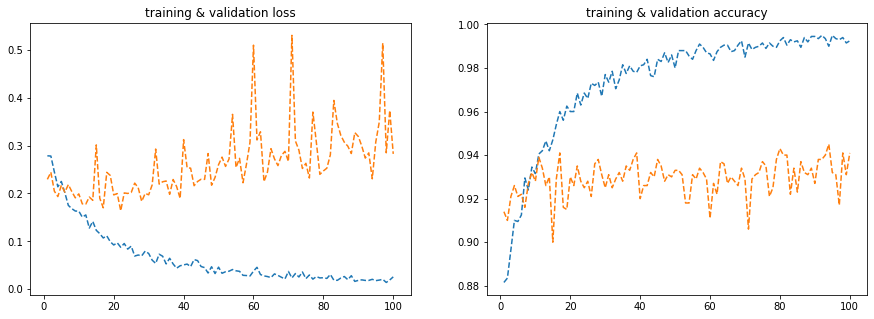

In [14]:
# plot model history
plot_model_training_history(history.history,chart_type="--")